In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from sod.jupyter.utils import * # our user defined functions
# Print a nice doc of the module functions just imported (`printdoc` is defined in `share`)
printdoc()

join,"Join two or more pathname components, inserting '/' as needed"
abspath,Return an absolute path.
dirname,Returns the directory component of a pathname
isfile,Test whether a path is a regular file
isdir,Return true if the pathname refers to an existing directory.
basename,Returns the final component of a pathname
splitext,Split the extension from a pathname
expanduser,Expand ~ and ~user constructions
sys,This module provides access to some objects used or maintained by the
os,OS routines for NT or Posix depending on what system we're on
re,Support for regular expressions (RE)


<div style='font-size:larger;line-height:1.5'>
<h3>This notebook takes the new dataset sod_dist_2_20 stream2segment, purges it<sup>[1]</sup>, displays some distributions and creates the following datasets<sup>[2]</sup>:</h3>
    <ul>
    <li><b>allset_train2</b>: all inliers of all datasets (Use allset_train + inliers of sod_dist_2_20)
        <li><b>allset2_test_AND_allset_unlabelled_annotation2</b>: allset_test_AND_allset_unlabelled_annotation2 plus N randomly sampled inliers (removed from sod_dist_2_20) where N ~= 0.1
    </ul>  
</div>

<sup>[1]</sup> (remove NA, i.e. rows with ALL PSd values NaN, and labels as outliers all PSD <-250 and >=0)<br>
<sup>[2]</sup> the new datasets are saved in the same folder of the three source datasets


In [2]:
import importlib

import os, pandas as pd, numpy as np
from joblib import dump, load
import sys
# sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
# from sod.jupyter.utils import *
# from sod.core.evaluation import normalize
import sod.core.dataset as sod_core_dataset
# importlib.reload(sod_core_dataset)
# import sod.core.plot as sod_plot
# importlib.reload(sod_plot)
import re

import importlib
# import sod.core.plot as sod_plot
# importlib.reload(sod_plot)
# import sod.core.dataset as sod_dataset
# importlib.reload(sod_dataset)
import matplotlib.pyplot as plt
import numpy as np


# defining matplotlib functions
import matplotlib.pyplot as plt
from contextlib import contextmanager

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


rootpath = os.path.join(os.path.dirname(os.getcwd()), 'datasets')
assert os.path.isdir(rootpath)

def read_dataset(name):
    datasetpath = os.path.join(rootpath, name + '.hdf')
    # assert os.path.isfile(datasetpath)
    printhtml('<h4>Reading dataset %s</h4>' % name)
    dataset = pd.read_hdf(datasetpath)
    dataset.channel_code = dataset.channel_code.astype('category')
    dataset.location_code = dataset.location_code.astype('category')
    # print('%s columns:' % name)
    # display(dataset.head(5))
    return dataset


def save_dataset(dataset, name):
    '''saves dataset (oandas dataframe). For security reasons
    (overwriting - i.e., loosing data of - big datasets might be really dangarous),
    this method raises if the file already exists'''
    datasetpath = os.path.abspath(os.path.join(rootpath, name + '.hdf'))
    if os.path.isfile(datasetpath):
        raise ValueError('Can not save dataset. File exists: "%s"' % datasetpath)
    if not re.match('^[a-zA-Z_]+$', name):
        raise ValueError('Can not save dataset. Invalid table name: "%s"' % name)
    dataset.to_hdf(
        datasetpath,
        format='table', mode='w',
        key=name
    )
    print('File saved under %s' % datasetpath)

    
def split_in_classes(dataset):
    return {
        'Inliers': dataset[dataset.hand_labelled & (~dataset.outlier)],
        'Outliers': dataset[dataset.hand_labelled & (dataset.outlier)],
        'Unlabelled': dataset[~dataset.hand_labelled],
    }


def print_stats(dataset):
    dfrs = split_in_classes(dataset)
    ret = {}
    for c, dfr in dfrs.items():
        if dfr.empty:
            continue
        string = f"{c} ({len(dfr):,d} rows)"
        ret[string] = sod_core_dataset._dfinfo(dfr).round(3)  # round to 3 decimals
    retdf = pd.concat(ret.values(), axis=1, keys=ret.keys())
    display(retdf)
    return retdf


def get_psd_columns(dataset):
    psd_cols = [_ for _ in dataset.columns if _.startswith('psd@')]
    return psd_cols


def remove_na(dataset):
    psd_cols = get_psd_columns(dataset)
    _len = len(dataset)
    ret = dataset.dropna(subset=psd_cols, how='all')  # , inplace=True)
    printhtml("Dropping NA (how=\'all\'), columns "
              f"{str(psd_cols)}: "
              f"<b>{_len - len(dataset)} rows removed</b>")
    return ret


def drop_artifacts(dataset):
    # here we set a threshold, and we remove all isntances that have PSD values outside that threshold
    CHECK = True  # check that rows with ANY column value artifact it's artifact for aLL column 
    TH = 1000
    is_na = pd.isna
    psd_cols = get_psd_columns(dataset)
    for i,c in enumerate(psd_cols):
        th_cond = (~dataset[c].between(-TH, TH, inclusive=False).values) | pd.isna(dataset[c])
        # we will warn if some instance has ANY value outside the threshold
        if i == 0:
            all_artifacts = th_cond
            any_artifact = th_cond
        else:
            all_artifacts = all_artifacts & th_cond
            any_artifact = any_artifact & th_cond
    
    # Check that there are NO segments for which ANY PSD column is an artifact BUT NOT ALL:
    ok_df = dataset[~all_artifacts]
    artifacts_df = dataset[all_artifacts]
    # check that if a row has any artifact, ALL columns are artifacts
    if all_artifacts.sum() != any_artifact.sum():
        dataset = dataset.reset_index(drop=True)
        _or_df = dataset[any_artifact]
        _and_df = dataset[all_artifacts]
        _diff_df = _or_df[~_or_df.index.isin(_and_df)]
        display(_diff_df.head(10))
        printhtml(f"<h4 style='color:red'>{len(_diff_df)} elements have one but not all PSD outside ({-TH}, {TH})."
                  "Check the dataset above and if you are ok with eliminating alsothose rows, "
                  "put the flag CHECK=False in the function 'drop_artifacts'</h4>")
    printhtml(f'Removing artifacts (segments with all rows not in ({-TH}, {TH}): '
              f'<b>{len(artifacts_df)} artifacts removed</b>')
    return ok_df, artifacts_df

    
# DEFINING SOME PLOT FUNCTONS:



@contextmanager
def plotparams(params):
    '''makes temporarily matplotlib params.
    Make sure to run this after %matplotlib inline.
    For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
    def_params = {k: plt.rcParams[k] for k in params}
    for k, v in params.items():
        plt.rcParams[k] = v
    try:
        yield
    finally:
        for k, v in def_params.items():
            plt.rcParams[k] = v

            
def set_same_lim(axes, x=True, y=True):
    minx, maxx, miny, maxy = np.inf, -np.inf, np.inf, -np.inf
    for ax in axes:
        minx = min(ax.get_xlim()[0], minx)
        maxx = max(ax.get_xlim()[1], maxx)
        miny = min(ax.get_ylim()[0], miny)
        maxy = max(ax.get_ylim()[1], maxy)
    for ax in axes:
        if x:
            ax.set_xlim(minx, maxx)
        if y:
            ax.set_ylim(miny, maxy)
    if x and y:
        return minx, maxx, miny, maxy
    elif x:
        return minx, maxx
    elif y:
        return miny, maxy
    else:
        raise ValueError('x and y can not be both False')

        
def plot_dist(dataset):
    psd_cols = get_psd_columns(dataset)
    # bins = np.arange(-350, 150, 5)

    # use colors which are ok also for grayscale:
    colors = ['#1f6784', '#ff7f3e', '#9cf09c']

    features = ['magnitude', 'distance_km'] + psd_cols
    bins = [np.arange(1, 10, 0.5), np.arange(0, 15000, 1000), np.arange(-500, 250, 10)]
    featurelabels = [_.title() for _ in features]

    axslist=[]
    ylims = []
    
    dfrs = split_in_classes(dataset)

    with plotparams({'figure.figsize': (12, 18), 'font.size': 12, 'figure.dpi': 150, 'font.family': 'helvetica,arial'}):
        fig, allaxs = plt.subplots(len(features), 2)
        # pltsubplots accepts also gridspec_kw to fix the subplots relative size, but apparently we do not
        # need it: , gridspec_kw={'height_ratios': [1] + [1]*(len(features)-1)})
        for i, col in enumerate(features):
            rowaxs = allaxs[i]
            inliers, outliers = list(dfrs.values())[0], list(dfrs.values())[1]
            for j, wtype in enumerate([True, False]):
                axs = rowaxs[j]
                data = outliers[outliers.window_type==wtype][col], inliers[inliers.window_type==wtype][col]
                label = 'signal part' if wtype else 'noise part'
                axs.set_xlabel(f'{featurelabels[i]} ({label})')
                try:
                    axs.hist(data, bins=bins[min(i, 2)], rwidth=.66,
                             log=True, histtype='bar', stacked=False,
                             edgecolor=colors[0],
                             color=[colors[0], 'white'])  # , label=featurelabels[i] + ' (%s)' % name
                             #color=colors[:len(data)])
                except:
                    pass
                axs.grid()

    plt.tight_layout()
    plt.show()

print('DONE')

DONE


In [3]:
print('READING DATASET, PLEASE WAIT IT MIGHT TAKE FEW MINUTES')
# databases = ['s2s_2019_03_at_rs5', 'me_at_rz_minus_vm258', 'sod_chile_at_rs5', 'sod_dist_2_20_at_rs5']


dsetnames = ['allset_train', 'allset_test_AND_allset_unlabelled_annotation2', 'sod_dist_2_20_at_rs5_relabelled']
dfr = read_dataset(dsetnames[-1])

_ = len(dfr)
# remove psd@5sec < 1000 because they are ertifacts and we do not want them (otherwise histogrms are messed up)
dfr = dfr[dfr['psd@5sec'] >= -1000]
flt = (dfr['psd@5sec'] <= -240) | (dfr['psd@5sec'] >= 0)
dfr.loc[flt, 'hand_labelled'] = True
dfr.loc[flt, 'outlier'] = True
assert (dfr.dataset_id == 4).all()
dfr = dfr[dfr.hand_labelled]
printhtml(f'<h4> Loaded {dsetnames[-1]}: keeping {len(dfr):,d} instances of {_:,d}</h4>')

# pd.set_option("display.max_rows", 2)
# display(dfr)

datasets = {dsetnames[-1]: dfr}
for name in dsetnames[:-1]:
    datasets[name] = read_dataset(name)

    
print('DONE')

READING DATASET, PLEASE WAIT IT MIGHT TAKE FEW MINUTES


Reading dataset sod_dist_2_20_at_rs5_relabelled

Loaded sod_dist_2_20_at_rs5_relabelled: keeping 20,110 instances of 36,972

Reading dataset allset_train

Reading dataset allset_test_AND_allset_unlabelled_annotation2

DONE


In [4]:
dfr.reset_index(drop=True, inplace=True)
dfrtrain = datasets[dsetnames[0]]
dfrtest = datasets[dsetnames[1]]


newtrain = [dfrtrain]
newtest = [dfrtest, dfr[dfr.outlier]]
RSTATE = 42
printhtml('<h4>Randomly sampling 10% of samples (after grouping per channel) from our Dataframe and putting them in test, the rest in train</h4>')
printhtml(f'Current Dataframe size: {len(dfr):,d}')
printhtml(f'Current train size: {len(dfrtrain):,d}')
printhtml(f'Current test size: {len(dfrtest):,d}')

_tmp = dfr[~dfr.outlier].reset_index(drop=True, inplace=False)
for (sid, loc, cha), df in _tmp.groupby(['station_id', 'location_code', 'channel_code']):
    if len(df) >= 10:
        test = dfr.sample(int(len(df)/10), random_state=RSTATE)
        train = df[~df.index.isin(test.index)]
        newtrain.append(train)
        newtest.append(test)
    else:
        newtrain.append(df)

newtrain = pd.concat(newtrain, sort=False, copy=True, axis=0, ignore_index=True)
newtest = pd.concat(newtest, sort=False, copy=True, axis=0, ignore_index=True)
print('DONE')
printhtml(f'New train size: {len(newtrain):,d}')
printhtml(f'Current test size: {len(newtest):,d}')


# printhtml(f'<h3>New train:</h3>')
# plot_dist(newtrain)

# printhtml(f'<h3>New test:</h3>')
# plot_dist(newtest)


Randomly sampling 10% of samples (after grouping per channel) from our Dataframe and putting them in test, the rest in train

Current Dataframe size: 20,110

Current train size: 1,892,367

Current test size: 850,164

DONE


New train size: 1,912,087

Current test size: 852,287

In [5]:
def magdist(dataframe, ceil=None):
    colx, coly = 'distance_km', 'magnitude'
    # CEIL = 5000
    # printhtml(f'<h4>Training segment distribution (signal parts ognly) with ceiling at {CEIL} segments per cell</h4>')
    dfr = heatmap_df(dataframe, colx, coly,
                         np.arange(0, 12000, 1000), np.arange(0.5, 9.5, 0.5))

    if ceil:
        dfr[dfr > ceil] = ceil
    print(f'{dfr.sum().sum():,d} instances')
    display(dfr.iloc[::-1])

    # Index= ['aaa', 'bbb', 'ccc', 'ddd', 'eee']
    # Cols = ['A', 'B', 'C', 'D']
    # df = DataFrame(abs(np.random.randn(5, 4)), index=Index, columns=Cols)

    plt.rcParams['figure.figsize'] = (8, 8)
    plt.rcParams['font.size'] = 12

    plt.pcolor(dfr, cmap='hot_r')
    plt.yticks(np.arange(0.5, len(dfr.index), 1), dfr.index)
    plt.xticks(np.arange(0.5, len(dfr.columns), 1), dfr.columns)
    plt.ylabel(coly)
    plt.xlabel(colx)
    plt.xticks(rotation=80)
    plt.grid()
    plt.show()
    return dfr


Testset Segment distribution (signal parts ognly) with no ceiling

432,829 instances


distance_km,"(0, 1000]","(1000, 2000]","(2000, 3000]","(3000, 4000]","(4000, 5000]","(5000, 6000]","(6000, 7000]","(7000, 8000]","(8000, 9000]","(9000, 10000]","(10000, 11000]"
magnitude,,,,,,,,,,,
"(8.5, 9.0]",0,0,3,8,14,77,18,5,30,54,15
"(8.0, 8.5]",6,0,6,19,14,71,11,8,22,39,20
"(7.5, 8.0]",10,0,250,117,223,219,238,246,420,386,488
"(7.0, 7.5]",0,1,260,396,366,606,559,394,607,1038,872
"(6.5, 7.0]",78,91,566,825,1316,1350,1336,1510,2148,3030,2506
"(6.0, 6.5]",268,95,1949,1796,3304,4560,4100,4289,6313,7484,5875
"(5.5, 6.0]",722,98,2052,3178,5969,7656,7109,7422,10283,14267,11237
"(5.0, 5.5]",2516,0,2932,3940,4723,4964,6437,7068,13755,17515,11741
"(4.5, 5.0]",10196,0,591,700,726,1077,1315,1238,2402,2964,2118


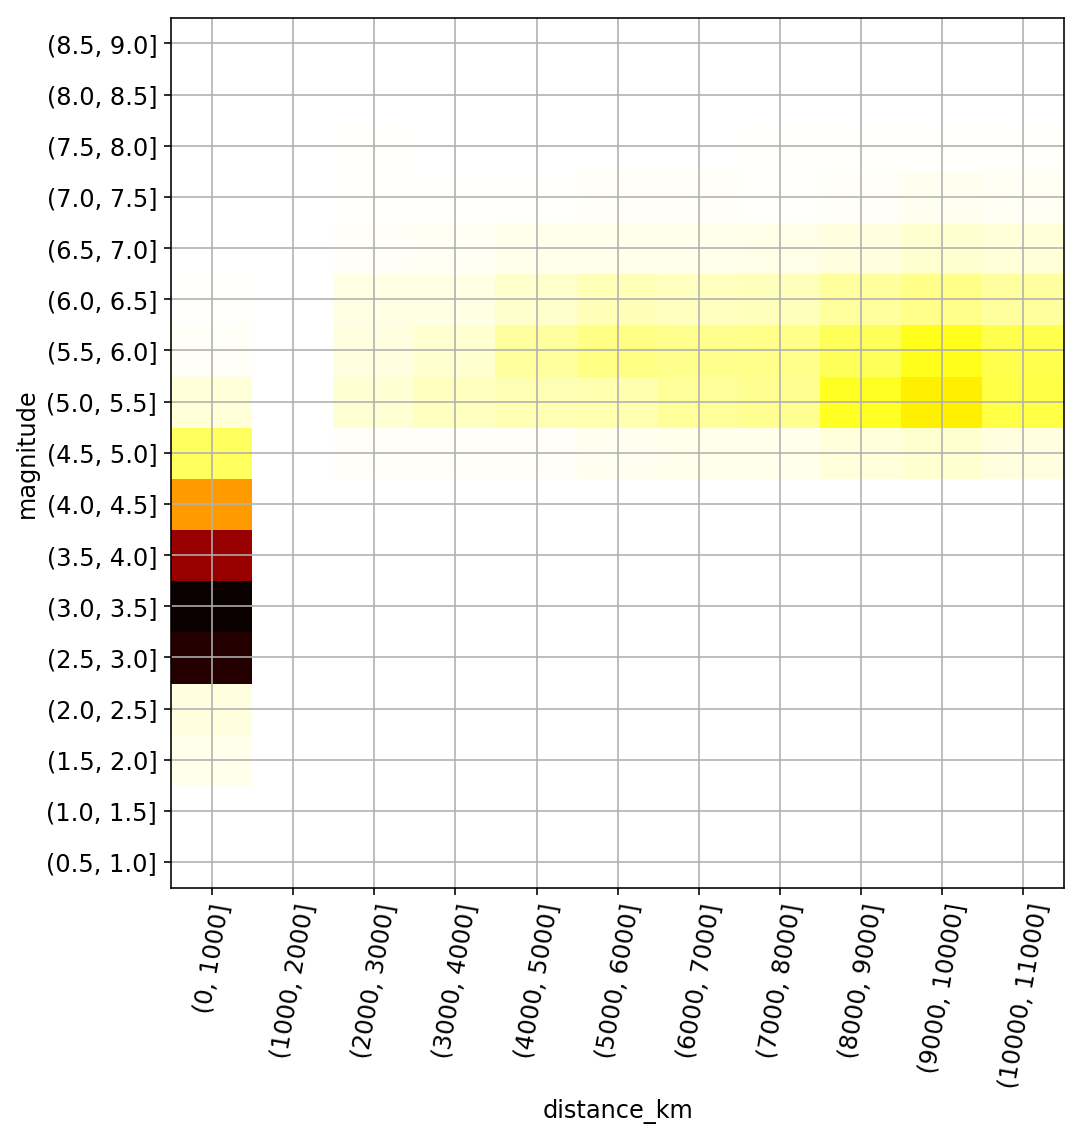

In [6]:
printhtml(f'<h4>Testset Segment distribution (signal parts ognly) with no ceiling</h4>')
hmttest = magdist(newtest[newtest.window_type])

Training segment distribution (signal parts ognly) with ceiling at 5000 segments per cell

272,880 instances


distance_km,"(0, 1000]","(1000, 2000]","(2000, 3000]","(3000, 4000]","(4000, 5000]","(5000, 6000]","(6000, 7000]","(7000, 8000]","(8000, 9000]","(9000, 10000]","(10000, 11000]"
magnitude,,,,,,,,,,,
"(8.5, 9.0]",1,4,17,17,27,45,44,30,77,220,40
"(8.0, 8.5]",106,10,21,26,34,45,32,49,68,184,110
"(7.5, 8.0]",132,67,339,347,580,778,690,741,896,1217,809
"(7.0, 7.5]",113,261,777,929,1363,1544,1395,1437,1855,3094,2039
"(6.5, 7.0]",931,1107,2003,2342,3594,4005,4283,4751,5000,5000,4945
"(6.0, 6.5]",2886,2569,4882,5000,5000,5000,5000,5000,5000,5000,5000
"(5.5, 6.0]",3294,880,5000,5000,5000,5000,5000,5000,5000,5000,5000
"(5.0, 5.5]",5000,0,5000,5000,5000,5000,5000,5000,5000,5000,5000
"(4.5, 5.0]",5000,0,2245,2036,2527,2949,3882,3823,5000,5000,4414


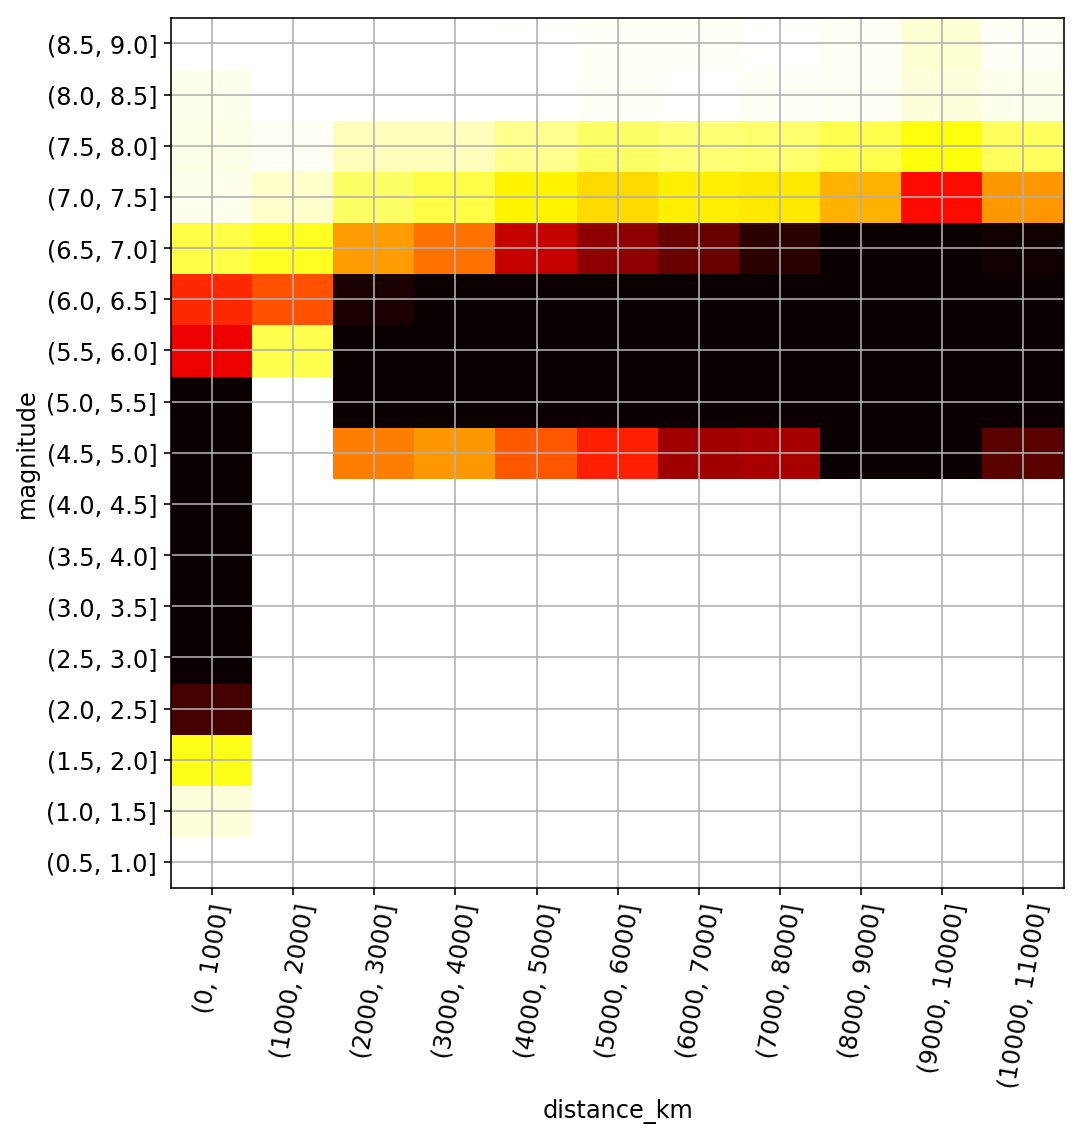

In [7]:
CEIL = 5000
printhtml(f'<h4>Training segment distribution (signal parts ognly) with ceiling at {CEIL} segments per cell</h4>')

hmtrain = magdist(newtrain[newtrain.window_type], CEIL)

In [8]:
printhtml('<h4>Resampling training set to get homogeneous samples per magnitude/distance cell</h4>')
homogeneous_train = []
RSTATE = 42
signaltrain = newtrain[newtrain.window_type]
print(f'Adding signal segments only: iterate over each [mag, dist] cell, group by channel, '
      'add a sampled number of segments such that the total '
      f'segments of the given cell does not exceeds {CEIL} segments')
pbar=progressbar(len(hmtrain.columns) * len(hmtrain.index))
for dinterval in hmtrain.columns:
    for minterval in hmtrain.index:
        pbar.update(1)
        dfr = signaltrain
        # filter segments within the cell:
        dfr = dfr[(dfr.magnitude > minterval.left) &
                 (dfr.magnitude <= minterval.right) &
                 (dfr.distance_km > dinterval.left) &
                 (dfr.distance_km <= dinterval.right)]
        gby = dfr.groupby(['station_id', 'location_code', 'channel_code'], sort=False)
        gbysize = gby.size()
        numsegments = gbysize.sum()
        numchannels = len(gbysize)
        frac = 1
        if numsegments > CEIL:
            frac = np.true_divide(CEIL, numsegments)
        for (sta, loc, cha), signaldf in gby:
            if frac == 1:
                homogeneous_train.append(signaldf)
            else:
                homogeneous_train.append(signaldf.sample(frac=frac, random_state=RSTATE))
            
# add noise (fraction of)
nfrac = 0.15
print(f'Adding noise segments only: group by channel, '
      'add a {frac} sampled number of segments (heuristically determined to have a roughly 50% noisy '
      'segment in the train (if too much chek the next cell result and adjust `nfrac` here)')
noisetrain = newtrain[~newtrain.window_type]
gby = noisetrain.groupby(['station_id', 'location_code', 'channel_code'], sort=False)
gbysize = gby.size()
numsegments = gbysize.sum()
numchannels = len(gbysize)
pbar=progressbar(numchannels)
for (sta, loc, cha), noisedf in gby:
    pbar.update(1)
    if len(noisedf)*nfrac <= 1:
        homogeneous_train.append(noisedf)
    else:
        homogeneous_train.append(noisedf.sample(frac=nfrac, random_state=RSTATE))

# del _tmptrain
print('Concatenating sub-dataframes into homogeneous trainingset (please wait)')
homogeneous_train = pd.concat(homogeneous_train, axis=0, ignore_index=True, copy=True, sort=False)
print('DONE')

Resampling training set to get homogeneous samples per magnitude/distance cell

Adding signal segments only: iterate over each [mag, dist] cell, group by channel, add a sampled number of segments such that the total segments of the given cell does not exceeds 5000 segments


[●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●] 100.0% 0:00:00

Adding noise segments only: group by channel, add a {frac} sampled number of segments (heuristically determined to have a roughly 50% noisy segment in the train (if too much chek the next cell result and adjust `nfrac` here)


[●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●] 100.0% 0:00:00

Concatenating sub-dataframes into homogeneous trainingset (please wait)
DONE


Homogeneous train: 405,835 instances

272,760 signal instances, 133,075 noise instances

Homogeneous train Segment distribution (signal parts ognly) with no ceiling

272,760 instances


distance_km,"(0, 1000]","(1000, 2000]","(2000, 3000]","(3000, 4000]","(4000, 5000]","(5000, 6000]","(6000, 7000]","(7000, 8000]","(8000, 9000]","(9000, 10000]","(10000, 11000]"
magnitude,,,,,,,,,,,
"(8.5, 9.0]",1,4,17,17,27,45,44,30,77,220,40
"(8.0, 8.5]",106,10,21,26,34,45,32,49,68,184,110
"(7.5, 8.0]",132,67,339,347,580,778,690,741,896,1217,809
"(7.0, 7.5]",113,261,777,929,1363,1544,1395,1437,1855,3094,2039
"(6.5, 7.0]",931,1107,2003,2342,3594,4005,4283,4751,5015,4997,4945
"(6.0, 6.5]",2886,2569,4882,5012,4998,4942,4953,4983,5011,5012,5011
"(5.5, 6.0]",3294,880,5031,5010,4999,4999,4984,4993,5001,4999,4991
"(5.0, 5.5]",5008,0,4986,5000,5002,4990,4988,5000,5005,4998,4997
"(4.5, 5.0]",4994,0,2245,2036,2527,2949,3882,3823,5001,5005,4414


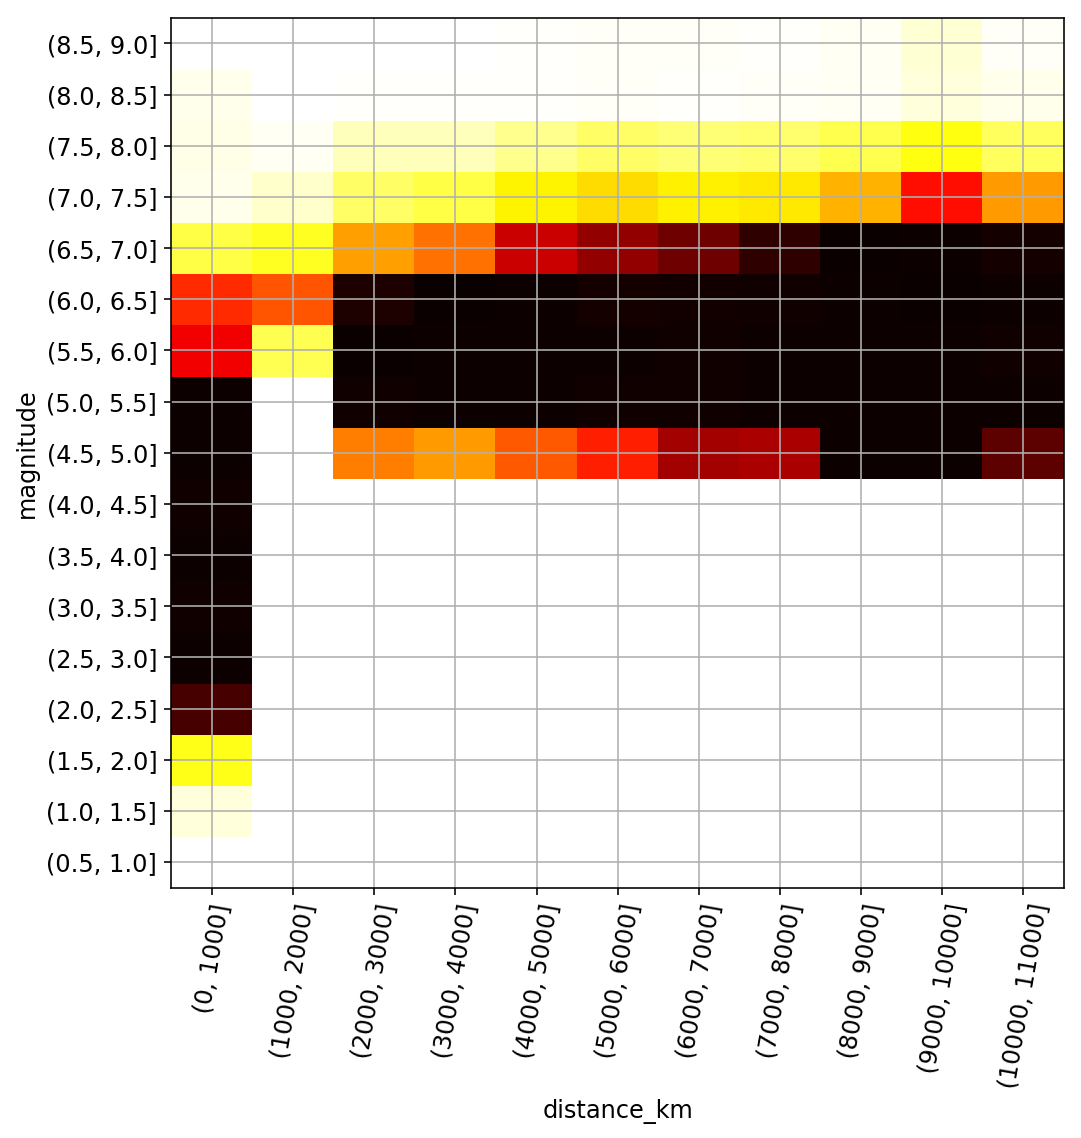

distance_km,"(0, 1000]","(1000, 2000]","(2000, 3000]","(3000, 4000]","(4000, 5000]","(5000, 6000]","(6000, 7000]","(7000, 8000]","(8000, 9000]","(9000, 10000]","(10000, 11000]"
magnitude,,,,,,,,,,,
"(0.5, 1.0]",4,0,0,0,0,0,0,0,0,0,0
"(1.0, 1.5]",189,0,0,0,0,0,0,0,0,0,0
"(1.5, 2.0]",1168,0,0,0,0,0,0,0,0,0,0
"(2.0, 2.5]",4561,0,0,0,0,0,0,0,0,0,0
"(2.5, 3.0]",4993,0,0,0,0,0,0,0,0,0,0
"(3.0, 3.5]",4990,0,0,0,0,0,0,0,0,0,0
"(3.5, 4.0]",4992,0,0,0,0,0,0,0,0,0,0
"(4.0, 4.5]",4990,0,0,0,0,0,0,0,0,0,0
"(4.5, 5.0]",4994,0,2245,2036,2527,2949,3882,3823,5001,5005,4414


In [9]:
printhtml(f'<h4>Homogeneous train: {len(homogeneous_train):,d} instances</h4>')
printhtml(f'<h4>{len(homogeneous_train[homogeneous_train.window_type]):,d} signal instances, {len(homogeneous_train[~homogeneous_train.window_type]):,d} noise instances</h4>')
printhtml(f'<h4>Homogeneous train Segment distribution (signal parts ognly) with no ceiling</h4>')
magdist(homogeneous_train[homogeneous_train.window_type])

Distributions plots

DATABASE: New dataframe sod_dist_2_20

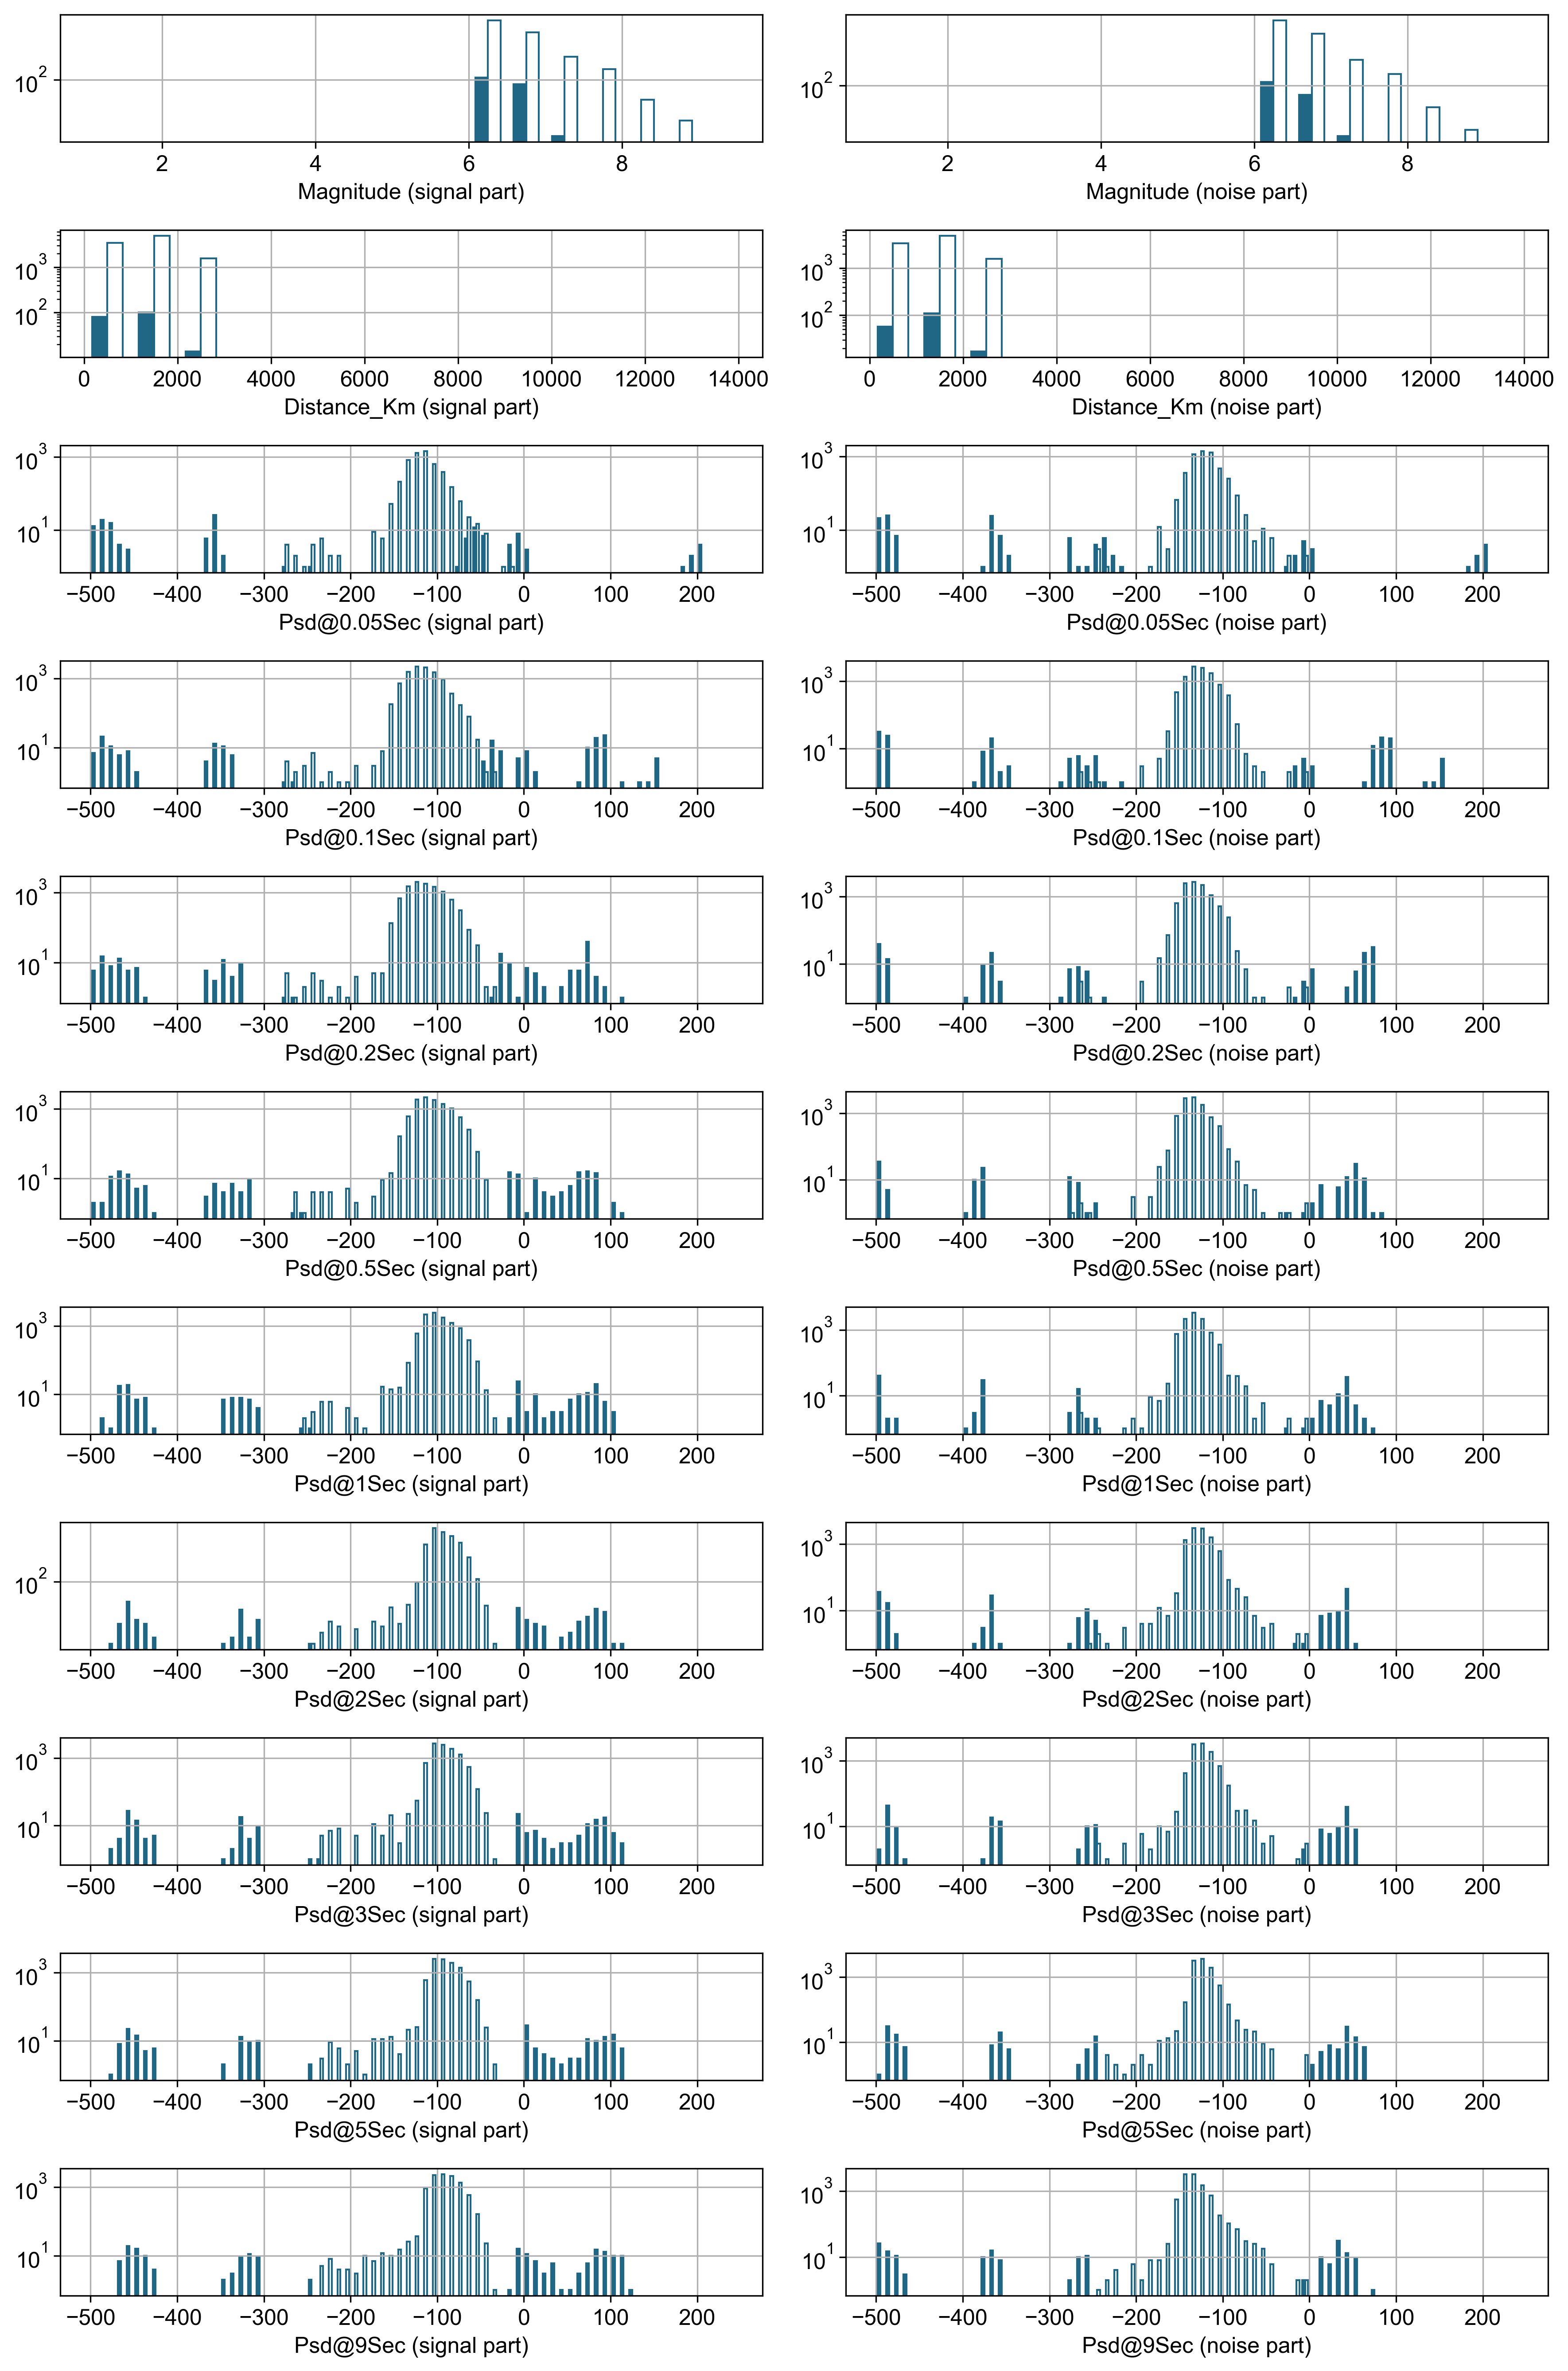

DATABASE: New train

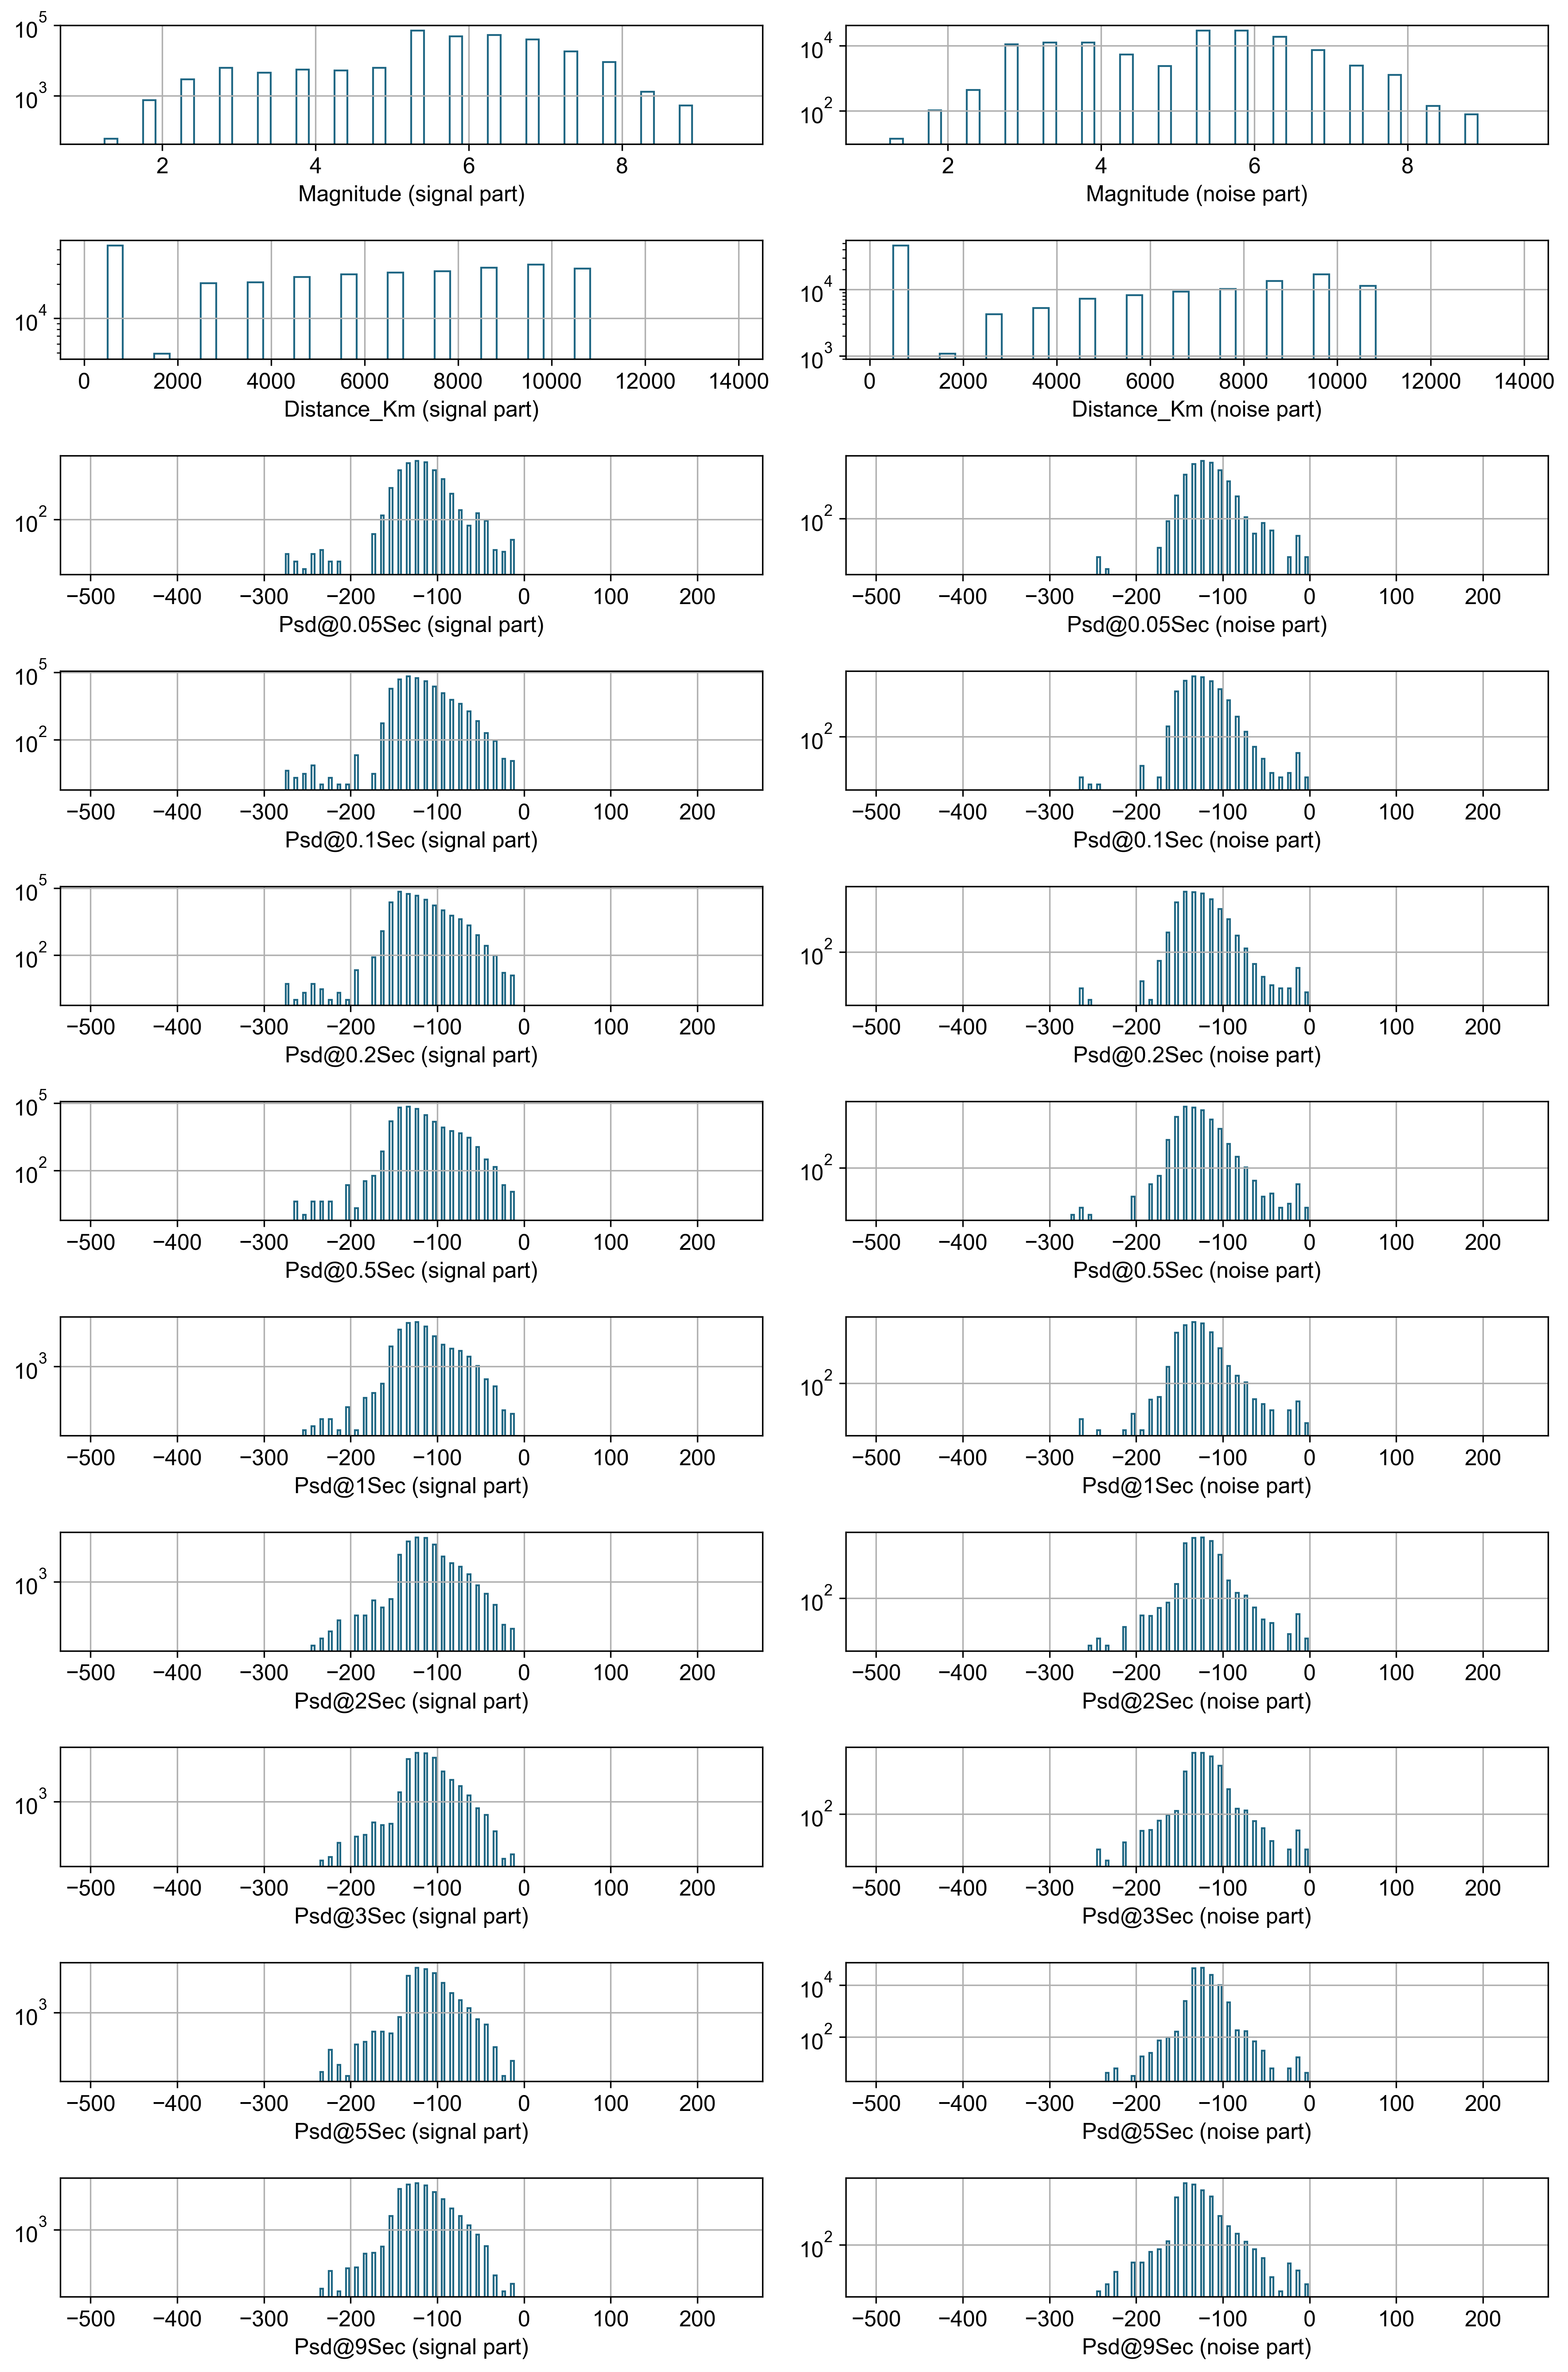

DATABASE: New test

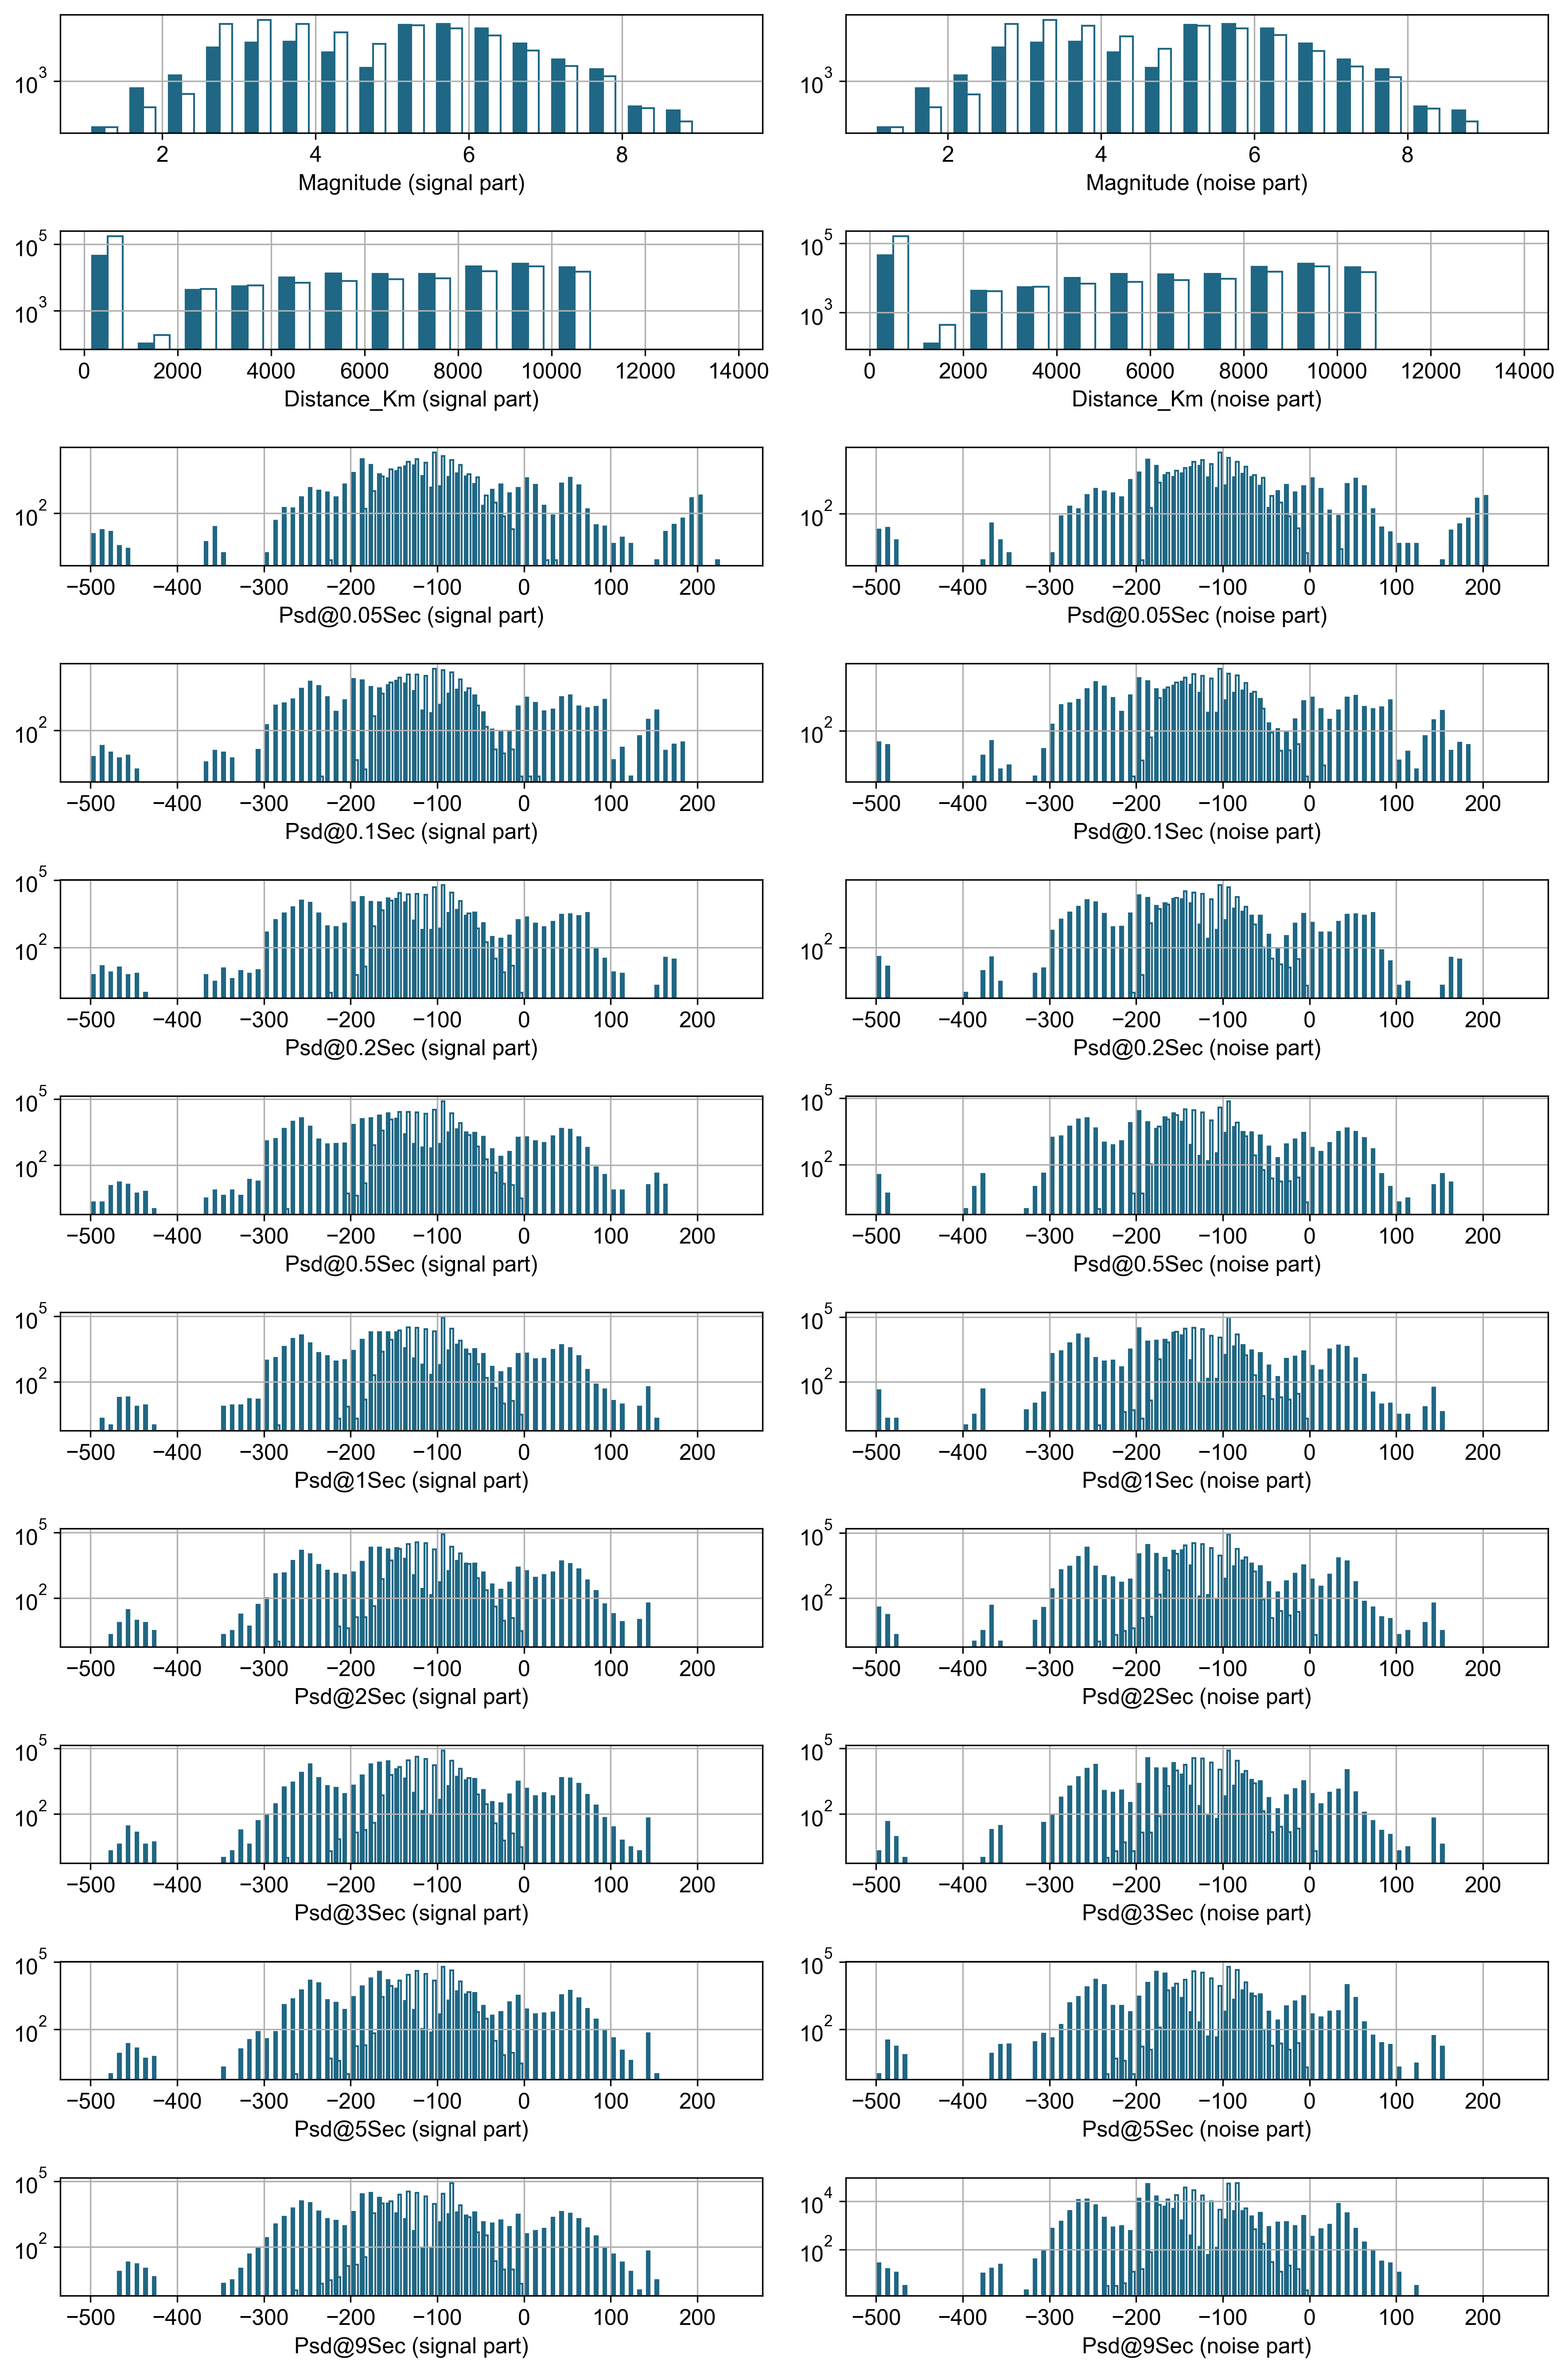

In [10]:
printhtml('<h3>Distributions plots</h4>')

name, dataset = 'New dataframe sod_dist_2_20', datasets[dsetnames[-1]]
printhtml(f'<h3>DATABASE: {name}</h3>')
plot_dist(dataset)

name, dataset = 'New train', homogeneous_train
printhtml(f'<h3>DATABASE: {name}</h3>')
plot_dist(dataset)


name, dataset = 'New test', newtest
printhtml(f'<h3>DATABASE: {name}</h3>')
plot_dist(dataset)







In [11]:
save_dataset(homogeneous_train, 'uniform_train')
save_dataset(newtest, 'uniform_test')

# Saving newly created datasets (train, test, unlabelled, artifacts)
# for name, dataset in new_datasets.items():
#     print_dec('Saving dataset "%s"' % name)
    # save_dataset(dataset, name)

File saved under /Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/uniform_train.hdf
File saved under /Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/uniform_test.hdf


In [12]:
for name, dfr in [('new train', homogeneous_train), ('new test', newtest)]:
    print()
    print(f'New train ')
    print(f'size: {len(dfr)} ')
    print(f'signal segments: {len(dfr[dfr.window_type])} ')
    print(f'outliers: {len(dfr[dfr.outlier])} ')
    print(f'hand labelled: {len(dfr[dfr.hand_labelled])} ')


New train 
size: 405835 
signal segments: 272760 
outliers: 0 
hand labelled: 405835 

New train 
size: 852287 
signal segments: 432835 
outliers: 337618 
hand labelled: 852287 
